## Оглавление

1. [Загрузка библиотек и данных](#load_data)
2. [Подготовка данных](#eda)
    * [Группировка данных по оттоку клиентов для просмотра средних значений](#2.1)
    * [Столбчатые гистограммы для оставшихся и ушедших клиентов](#2.2)
	* [Матрица корреляции](#2.3)
3. [Модель прогнозирования оттока клиентов](#prediction_model)
    * [Разбивка данных на обучающую и валидационную выборку функцией train_test_split()](#3.1)
    * [Обучение модели на train-выборке](#3.2)
    * [Оценка метрик accuracy, precision и recall для обеих моделей на валидационной выборке.](#3.3)
3. [Кластеризация клиентов](#clustering_clients)
    * [Стандартизируем данные, строим дендограмму<](#4.1)
	* [Обучение модели кластеризации на основании алгоритма K-Means. Прогноз кластеров клиентов](#4.2)
    * [Средние значения признаков для кластеров](#4.3)
    * [Распределение признаков для кластеров](#4.4)
	* [Доля оттока по кластерам](#4.5)
5. [Выводы](#conclusion)

## Описание проекта

**Задача**

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.

Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Как понять, что клиент больше не с вами? Можно записать в отток тех, кто попросил закрыть договор или удалил аккаунт. Однако клиенты не всегда уходят демонстративно: чаще перестают пользоваться сервисом тихо.

Индикаторы оттока зависят от специфики отрасли. Когда пользователь редко, но стабильно закупается в интернет-магазине — не похоже, что он «отвалился». А вот если две недели не заходит на канал с ежедневно обновляемым контентом, дела плохи: подписчик заскучал и, кажется, оставил вас.

Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. Конечно, не исключено, что он уехал на Бали и по приезде обязательно продолжит ходить на фитнес. Однако чаще бывает наоборот. Если клиент начал новую жизнь с понедельника, немного походил в спортзал, а потом пропал — скорее всего, он не вернётся.

Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. Ваша задача — провести анализ и подготовить план действий по удержанию клиентов.
<br>
<br>
<br>
**Описание данных, таблица gum_churn:**

Данные клиента за предыдущий до проверки факта оттока месяц:
 - gender — пол;
 - Near_Location — проживание или работа в районе, где находится фитнес-центр;
 - Partner — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
 - Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
 - Phone — наличие контактного телефона;
 - Age — возраст;
 - Lifetime — время с момента первого обращения в фитнес-центр (в месяцах).

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
 - Contract_period — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
 - Month_to_end_contract — срок до окончания текущего действующего абонемента (в месяцах);
 - Group_visits — факт посещения групповых занятий;
 - Avg_class_frequency_total — средняя частота посещений в неделю за все время с начала действия абонемента;
 - Avg_class_frequency_current_month — средняя частота посещений в неделю за предыдущий месяц;
 - Avg_additional_charges_total — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.

Churn — факт оттока в текущем месяце.

## <a id="load_data">Загрузка библиотек и данных</a>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import transforms
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
# загрузка файла с данными
fitnes = pd.read_csv('/datasets/gym_churn.csv')

In [3]:
# установим стандартный размер графиков для всего документа
%matplotlib inline
sns.set(rc={'figure.figsize':(20, 10)})

In [4]:
# просмотр первичной информации
display(fitnes.head(10))
display(fitnes.info())
display(fitnes.describe())

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
5,1,1,0,0,1,1,1,34,450.743960,1.0,3,2.623477,2.637007,0
6,1,1,1,1,0,6,1,32,94.266389,6.0,2,1.138941,1.277242,0
7,0,1,0,0,1,1,0,30,217.786641,1.0,0,1.213502,1.049387,1
8,1,1,1,1,1,1,1,23,45.409909,1.0,1,1.106239,1.059333,0
9,0,1,0,0,1,1,0,31,65.310836,1.0,11,1.810852,1.951368,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

None

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


In [5]:
# приведем названия колонок к нижнему регистру
fitnes.columns = fitnes.columns.str.lower()
fitnes.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

In [6]:
# приведем срок окончания действия абонемента к целочисленному виду
fitnes['month_to_end_contract'] = fitnes['month_to_end_contract'].astype(np.int64)
fitnes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   int64  
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

In [7]:
fitnes.isna().sum()

gender                               0
near_location                        0
partner                              0
promo_friends                        0
phone                                0
contract_period                      0
group_visits                         0
age                                  0
avg_additional_charges_total         0
month_to_end_contract                0
lifetime                             0
avg_class_frequency_total            0
avg_class_frequency_current_month    0
churn                                0
dtype: int64

In [8]:
fitnes.duplicated().sum()

0

**После первого осмотра данных:**
 - пропусков в данных нет;
 - дубликатов нет;
 - данные пригодны для дальнейшего анализа.

## <a id="eda">Исследовательский анализ данных (EDA)</a>

### <a id="2.1">Группировка данных по оттоку клиентов для просмотра средних значений</a>

In [9]:
fitnes.groupby('churn').mean().T.round(2)

churn,0,1
gender,0.51,0.51
near_location,0.87,0.77
partner,0.53,0.36
promo_friends,0.35,0.18
phone,0.90,0.90
contract_period,5.75,1.73
group_visits,0.46,0.27
age,29.98,26.99
avg_additional_charges_total,158.45,115.08
month_to_end_contract,5.28,1.66


Первичные выводы из данных:

 - мужчина и женщина - примерно одинаковое количество тех и других;
 - возраст - 27-30 года;
 - проживают или работают в районе, где находится фитнес-центр - 87 % и 77 % из оттока;
 - сотрудники компаний-партнёров клуба составляют 53 %, отток из этой группы составляет 36%;
 - факт первоначальной записи в рамках акции «приведи друга» - 35 %, отток составил 18%;
 - длительность текущего действующего абонемента - в среднем клиенты берут абонемент на 6 мес.;
 - факт посещения групповых занятий активных клиентов 46%, из ушедших эти занятия посещали 27%;
 - суммарная выручка от других услуг фитнес-центра(кафе, спорт-товары, косметический и массажный салон) - средние значения от 115 до 158;
 - время с момента первого обращения в фитнес-центр (в месяцах) - в среднем колиенты "живут" около 5 мес., отток обычно происходит после первого месяца;
 - средняя частота посещений в неделю за все время с начала действия абонемента и за последний месяц - 2 раза;

Первичные факторы оттока клиентов:

 - отсутствие специальных льготных условий обслуживания: компания-партнер или акция "приведи друга";
 - абонементы: возможно стоит добавить трехмесячный;
 - одномесячный абонемент лучше не убирать: есть риск потерять большую долю перспективных клиентов;
 - большой отток после первого месяца происходит;
 - малое количество посещений в неделю.

### <a id="2.2">Столбчатые гистограммы для оставшихся и ушедших клиентов</a>

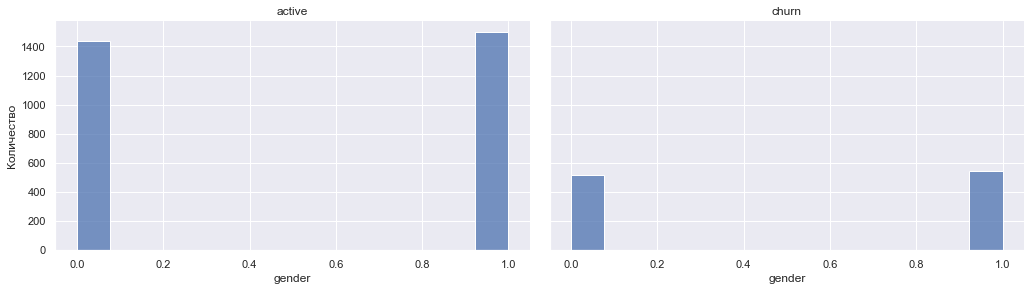

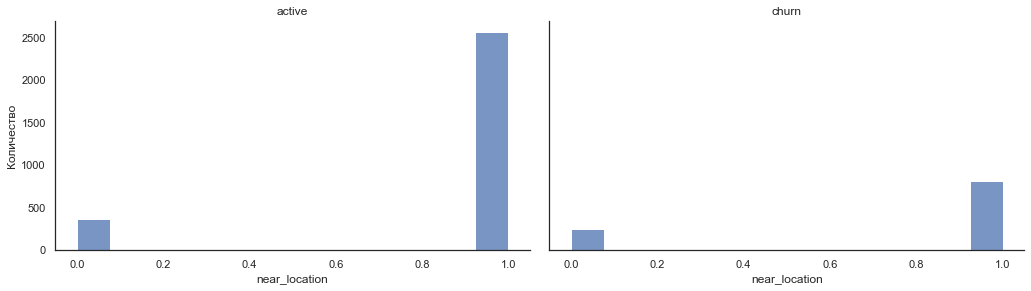

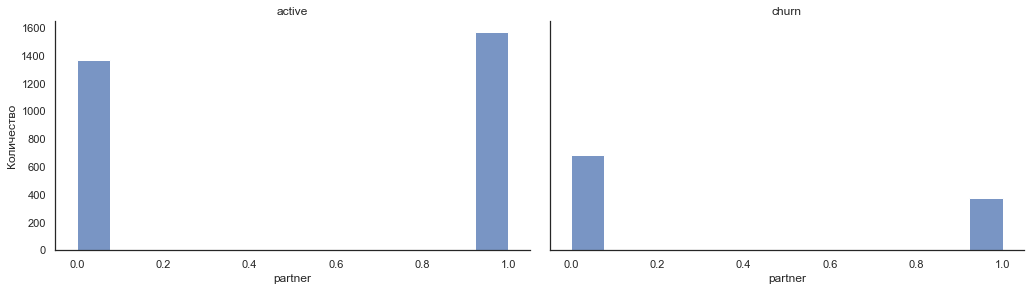

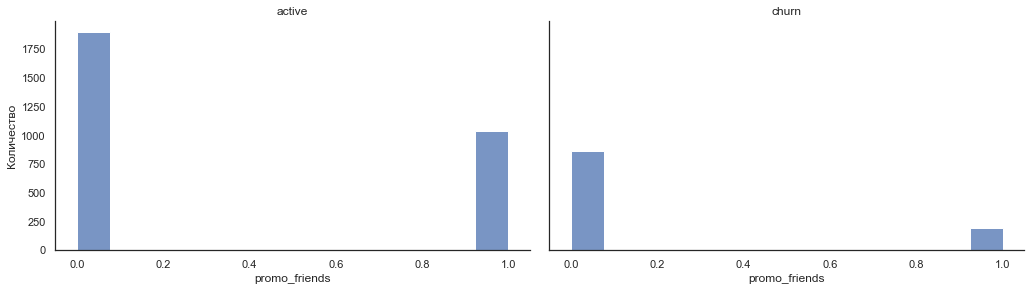

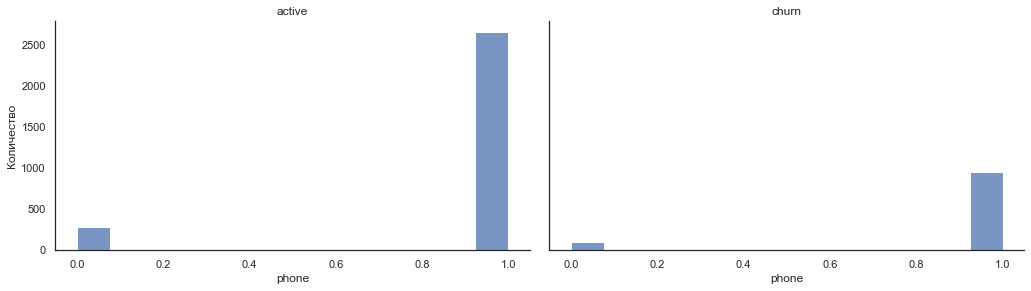

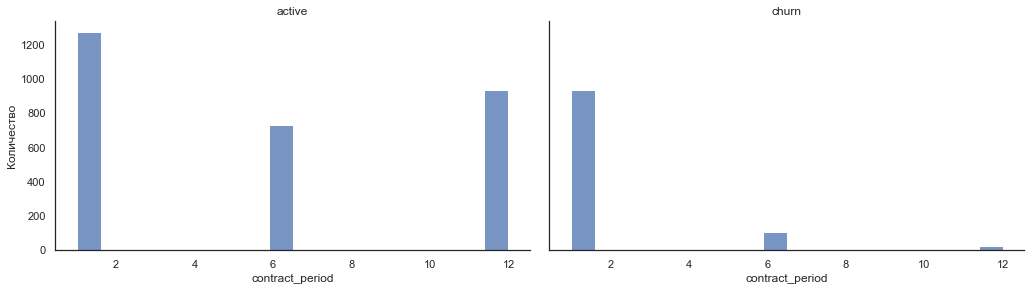

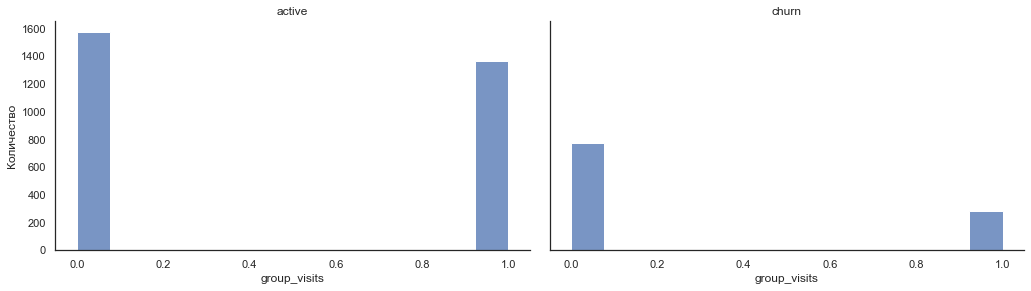

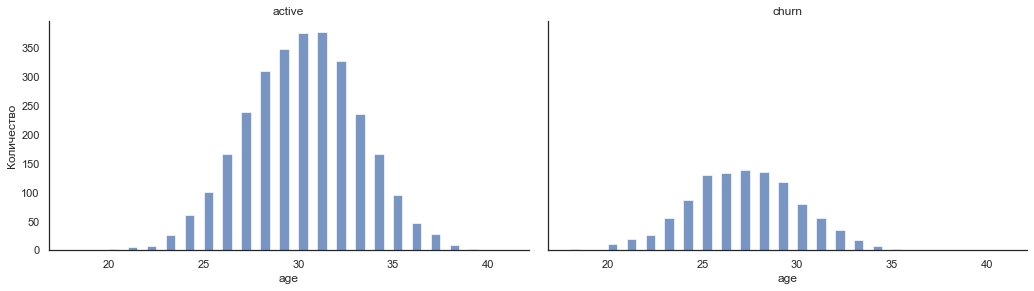

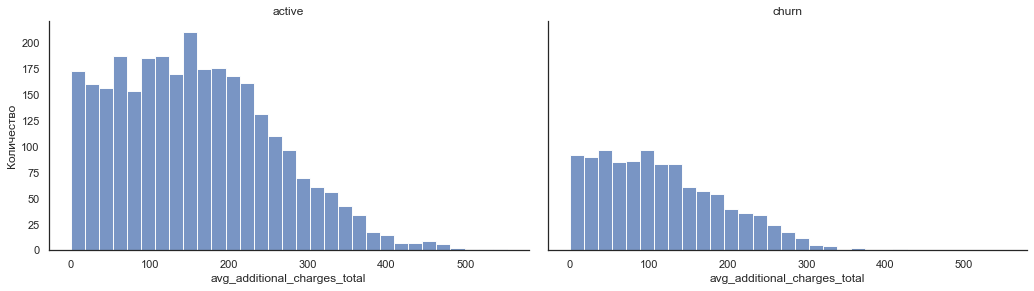

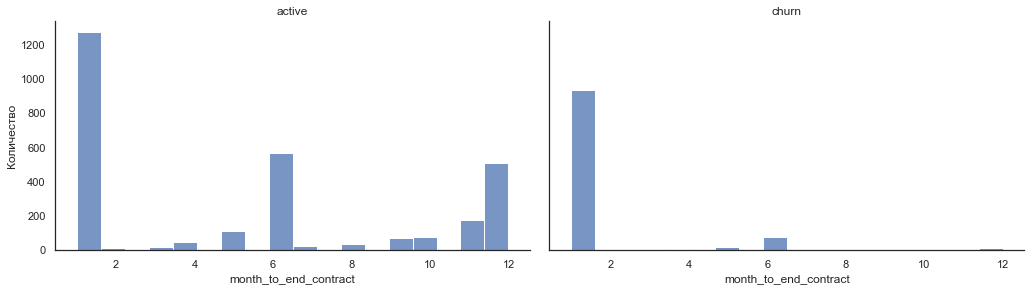

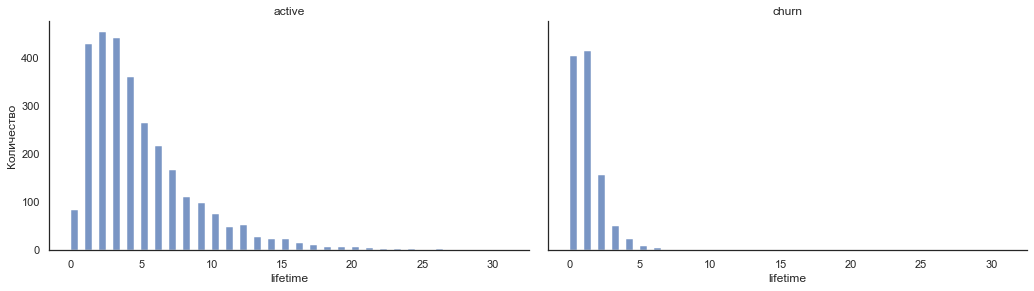

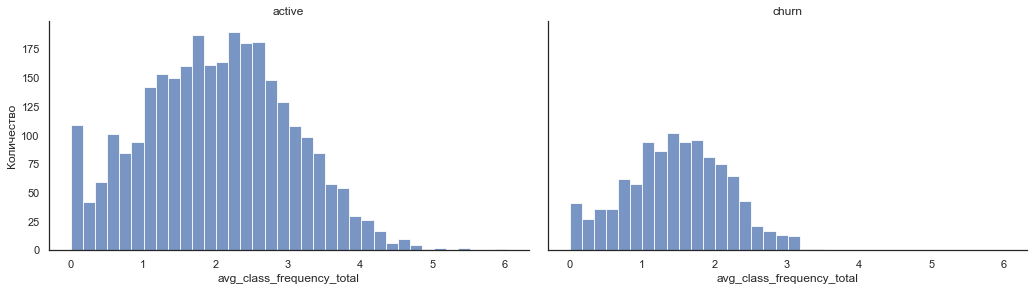

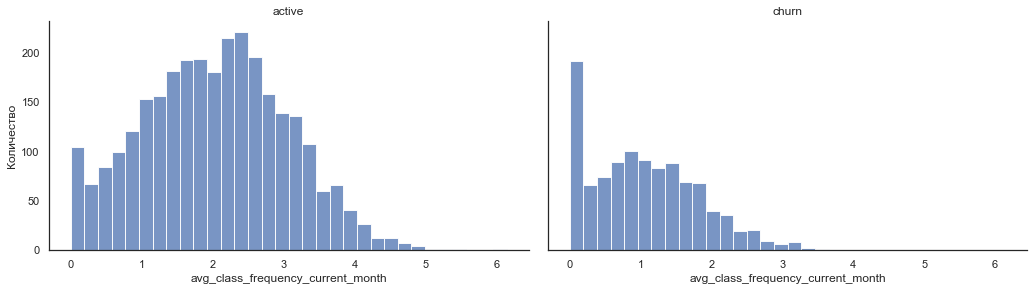

In [10]:
X = fitnes.drop(columns='churn')
fitnes_graph = fitnes.copy()
fitnes_graph['churn'] = fitnes_graph['churn'].replace([1,0],['churn','active'])

for name in X.columns:
  g = sns.displot(data=fitnes_graph, x=name, col="churn", palette="pastel")
  sns.set_style(style='white')
  g.fig.set_figwidth(15)
  g.fig.set_figheight(4)
  g.set_axis_labels(name, "Количество")
  g.set_titles("{col_name}");
  plt.show()

В целом гистограммы подтверждают данные полученные из таблицы выполненой методом группировки.

### <a id="2.3">Матрица корреляции</a>

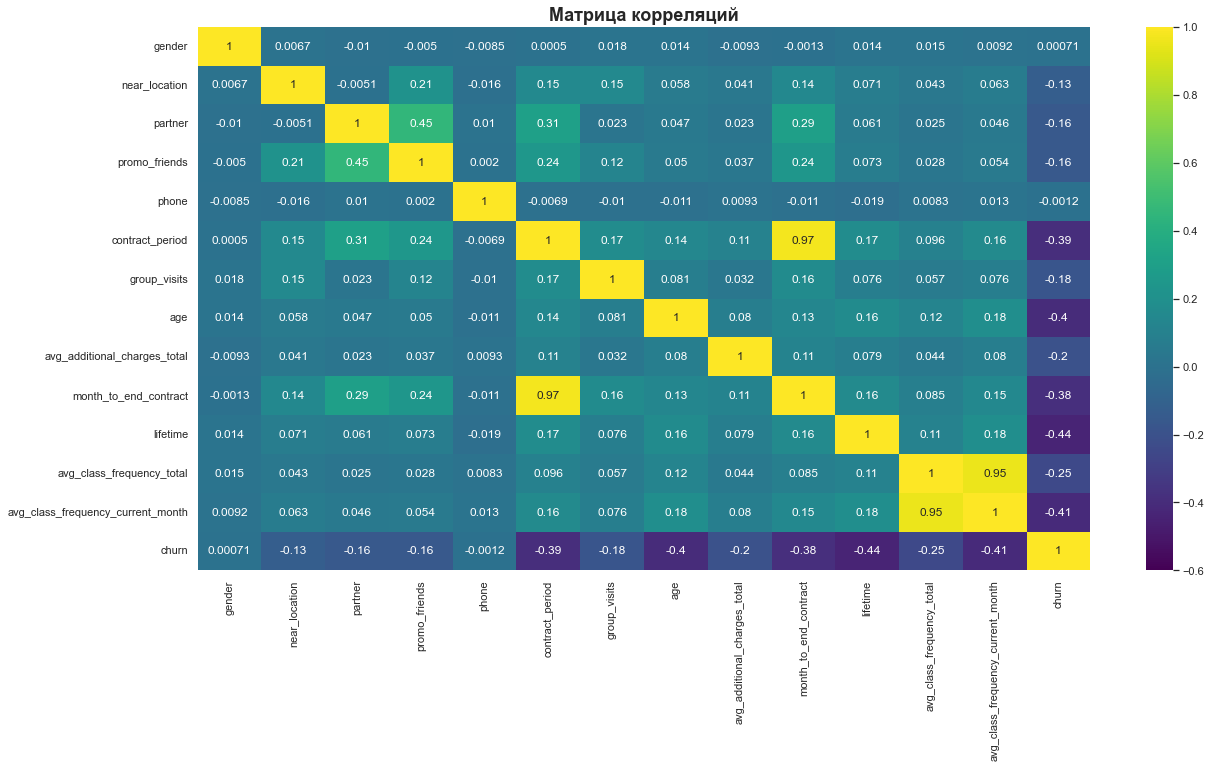

In [11]:
# строим матрицу
sns.heatmap(fitnes.corr(), annot=True, fmt='.2g', cmap='viridis', vmin=-0.6)
plt.title('Матрица корреляций', fontsize = 18, fontweight='bold')
plt.show()

Две пары коррелирующих параметров, весьма логичны:
 - период абонемента и время до окончания действия абонемента;
 - средняя частота посещения с начала действия абонемента и средняя частота посещений в неделю.

Думаю что такая корреляция может повлиять на объективность модели прогнозирования, надо убрать корреляцию.

## <a id="prediction_model">Модель прогнозирования оттока клиентов</a>

### <a id="3.1">Разбивка данных на обучающую и валидационную выборку функцией train_test_split()</a>

In [12]:
# удалим коррелирующие данные для объективной работы модели
fitnes_mod = fitnes.copy()
fitnes_mod = fitnes_mod.drop(['month_to_end_contract', 'avg_class_frequency_total'], axis=1)

In [13]:
# разделим данные на обучающий и проверяющий, думаю стоит применить параметр stratify для уравнения кол-ва экземпляров каждого класса
X = fitnes_mod.drop('churn', axis=1)
y = fitnes_mod['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [14]:
# стандартизируем данные
scaler = StandardScaler()
scaler.fit(X_train)
X_train_st = scaler.transform(X_train) 
X_test_st =  scaler.transform(X_test)

### <a id="3.2">Обучение модели на train-выборке</a>

In [15]:
# зададим алгоритм для модели логистической регрессии
lr_model = LogisticRegression(random_state = 0)

# обучим модель
lr_model.fit(X_train_st, y_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:,1]

In [16]:
# зададим алгоритм для новой модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)

# обучим модель случайного леса
rf_model.fit(X_train_st, y_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]

### <a id="3.3">Оценка метрик accuracy, precision и recall для обеих моделей на валидационной выборке.</a>

 - Accuracy: доля правильных ответов
 - Precision: точность (англ. precision)
 - Recall: полнота

In [17]:
def print_metrics(y_true, y_pred, y_proba, title):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))

In [18]:
# выведем метрики
print_metrics(y_test, lr_predictions, lr_probabilities, 'Метрики для модели логистической регрессии:')
print_metrics(y_test, rf_predictions, rf_probabilities, 'Метрики для модели случайного леса:')

Метрики для модели логистической регрессии:
	Accuracy: 0.92
	Precision: 0.85
	Recall: 0.84
Метрики для модели случайного леса:
	Accuracy: 0.91
	Precision: 0.85
	Recall: 0.77


По результатам проверки более приемлема модель метрик логической регрессии.

## <a id="clustering_clients">Кластеризация клиентов</a>

### <a id="4.1">Стандартизируем данные, строим дендограмму</a>

In [19]:
fitnes_stand = scaler.fit_transform(fitnes.drop(columns = ['churn'])) 

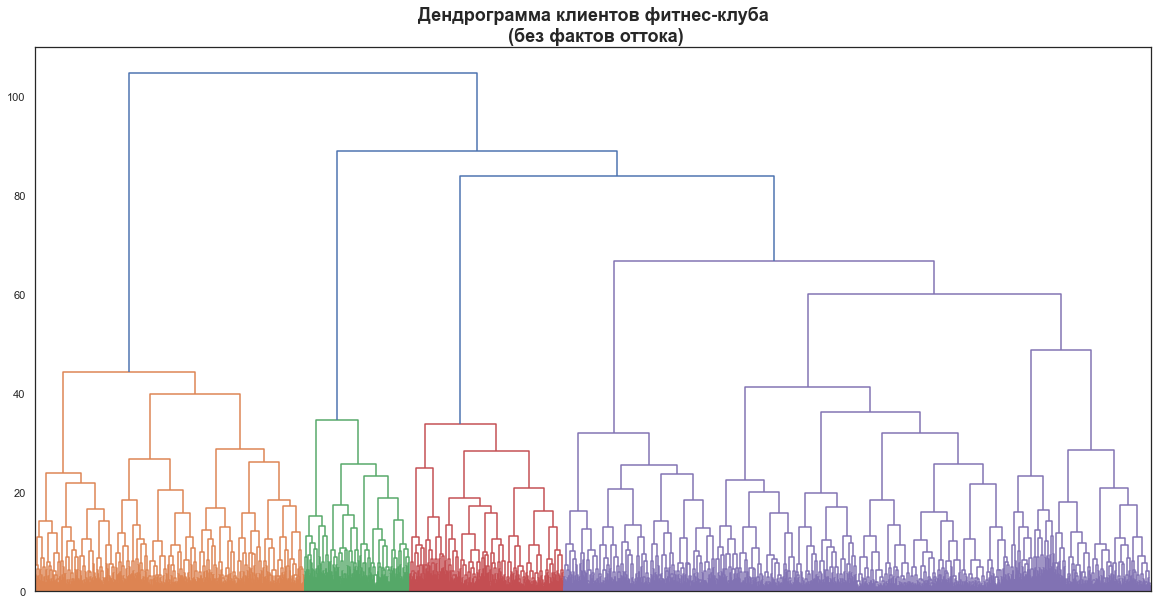

In [20]:
linked = linkage(fitnes_stand, method = 'ward')
dendrogram(linked, orientation='top', no_labels=True)
plt.title('Дендрограмма клиентов фитнес-клуба\n (без фактов оттока)', size=18, fontweight='bold')
plt.show() 

Без столбца с оттоком мы получаем 4 кластера, с весьма большим объемом последнего кластера. Попробуем вернуть обратно факты оттока.

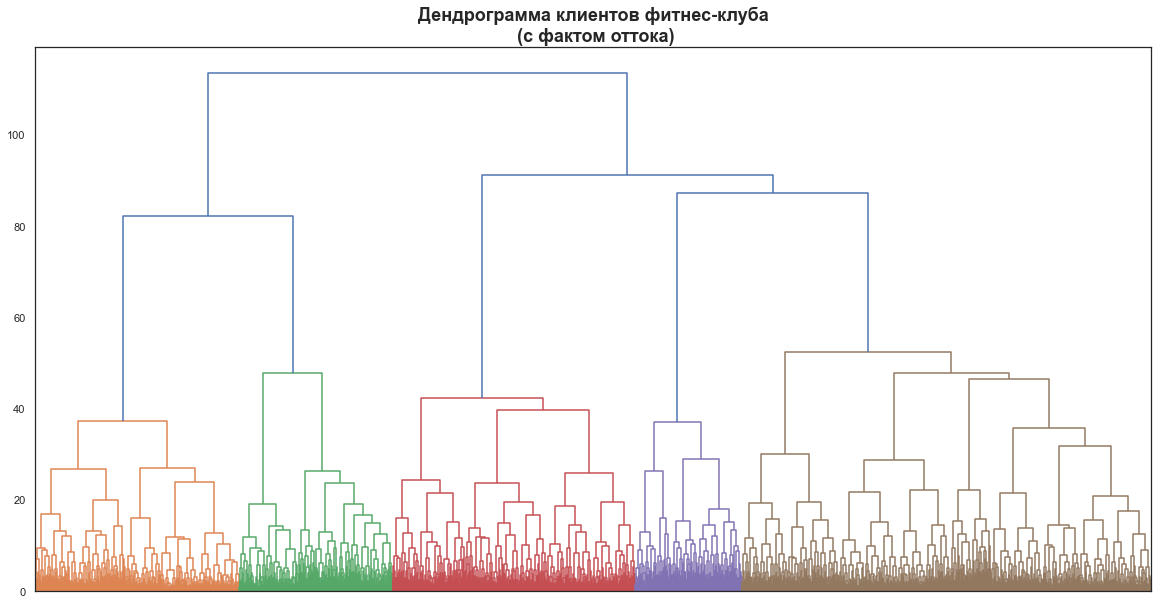

In [21]:
fitnes_stand = scaler.fit_transform(fitnes)
linked = linkage(fitnes_stand, method = 'ward')
dendrogram(linked, orientation='top', no_labels=True)
plt.title('Дендрограмма клиентов фитнес-клуба\n (c фактом оттока)', size=18, fontweight='bold')
plt.show() 

Судя по виду дендограммы наличие пятого кластера выглядит более корректно.

### <a id="4.2">Обучение модели кластеризации на основании алгоритма K-Means. Прогноз кластеров клиентов</a>

In [22]:
# зададим число кластеров n=5, сформируем вектор кластеров
k_mean = KMeans(n_clusters = 5, random_state=0)
labels = k_mean.fit_predict(fitnes_stand)

In [23]:
# сохраним показатели кластеров в новом столбце
fitnes['clusters'] = labels

In [24]:
# посмотрим на качество кластеризации
fitnes_stand = scaler.fit_transform(fitnes)
silhouette_score(fitnes_stand, labels)

0.17411035347503936

Качество кластеризации оставляет желать лучшего

### <a id="4.3">Средние значения признаков для кластеров</a>

In [25]:
# сгруппируем данные по кластерам
fitnes.groupby('clusters').mean().T.round(2)

clusters,0,1,2,3,4
gender,0.50,0.49,0.51,0.52,0.52
near_location,0.00,0.94,1.00,1.00,0.97
partner,0.46,0.76,0.32,0.28,0.74
promo_friends,0.08,0.53,0.21,0.21,0.53
phone,0.92,0.92,0.90,0.90,0.87
contract_period,2.07,10.45,1.55,1.88,8.86
group_visits,0.21,0.52,0.29,0.45,0.53
age,28.52,29.96,26.93,30.24,29.73
avg_additional_charges_total,132.74,161.85,113.17,157.99,162.91
month_to_end_contract,1.95,9.48,1.50,1.79,8.16


Какие выводы можно сделать из анализа кластеров:

 - самый не надежный кластер - №2: 96% оттока, посещают занятия один раз в неделю, "отваливаются" примерно через месяц, возрастная группа кластера около 27 лет;
 - самые надежные кластеры - №1 и №3: возрастная группа ~30 лет, хороший доход от доп.услуг, стабильно посещают занятия 2 - 3 раза в день;
 - из кластера №4 люди тоже не уходят, но есть риск появления оттока из-за плохой посещаемости занятий;
 - нулевой кластер - стабильная серединка.

### <a id="4.4">Распределение признаков для кластеров</a>

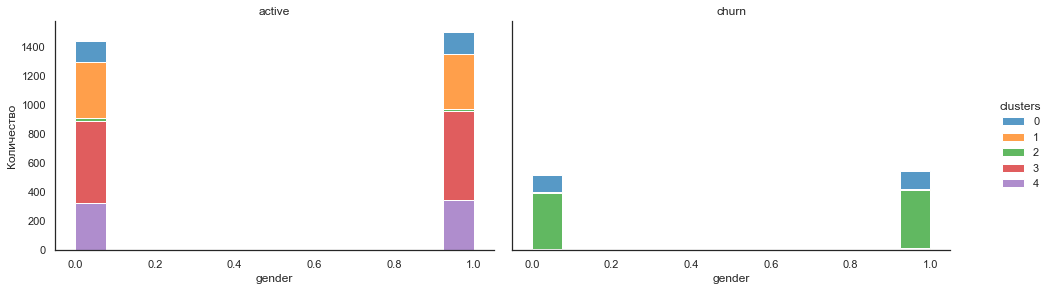

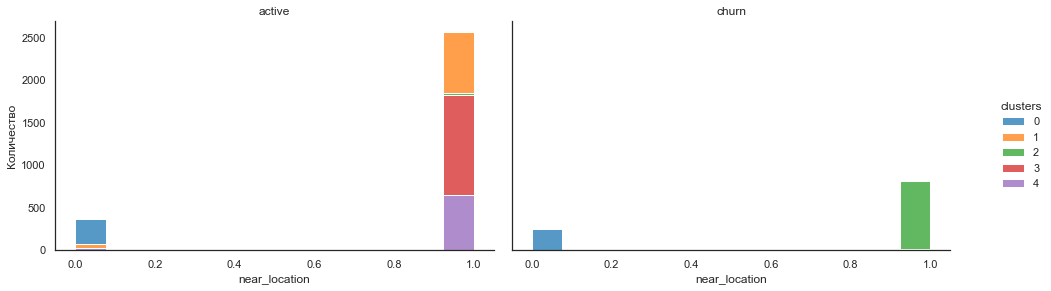

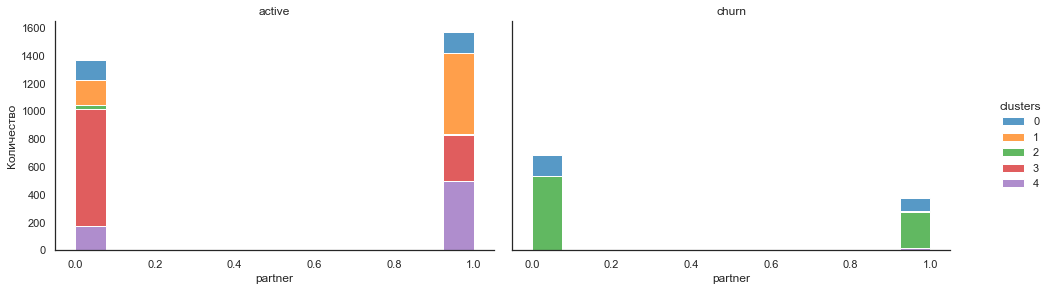

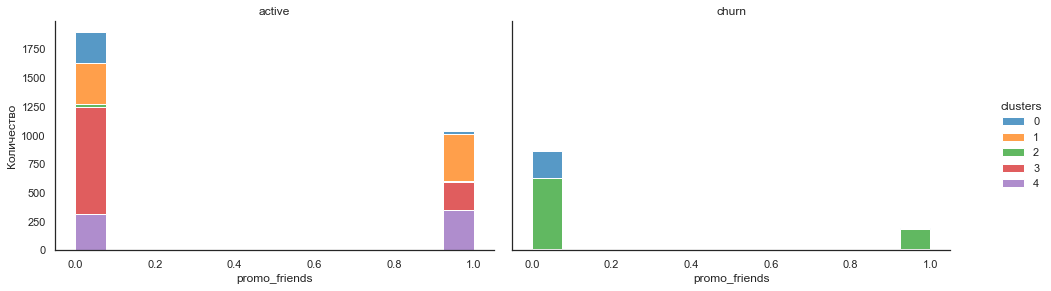

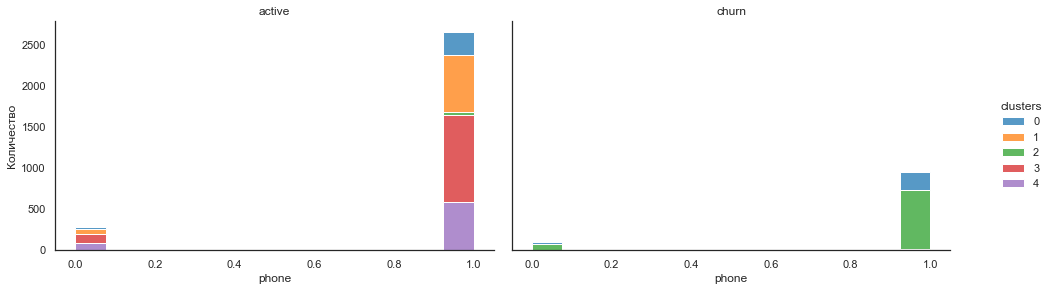

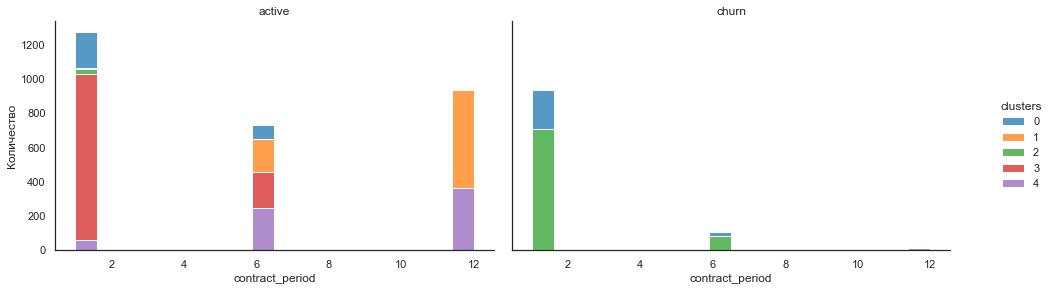

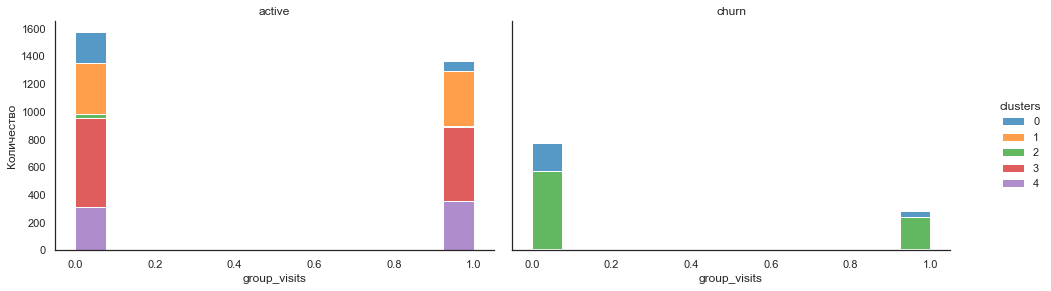

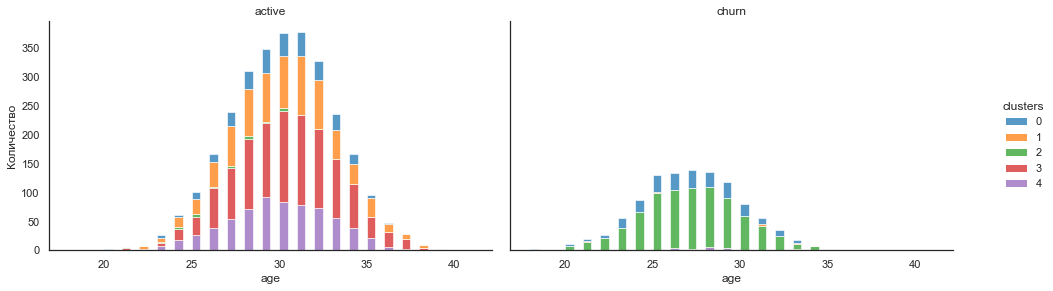

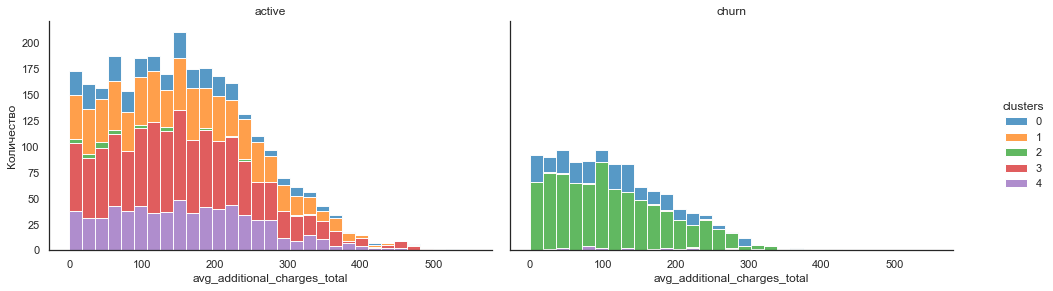

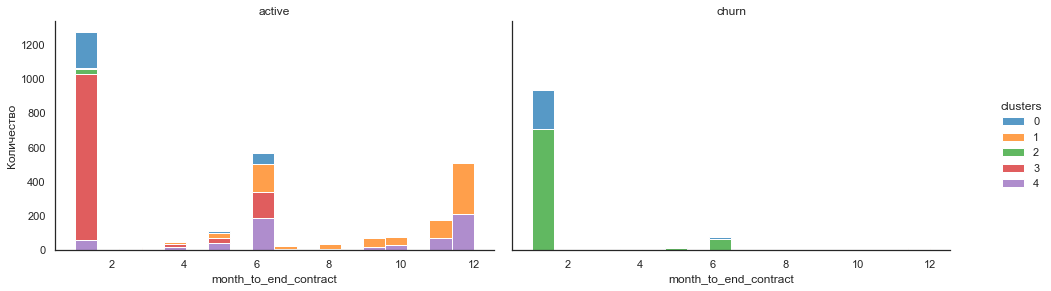

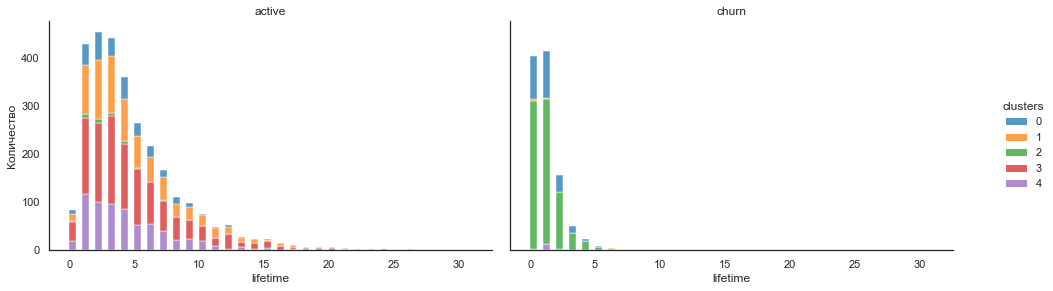

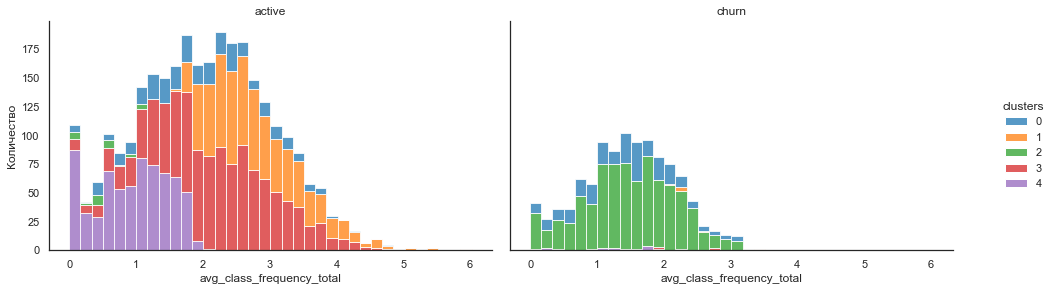

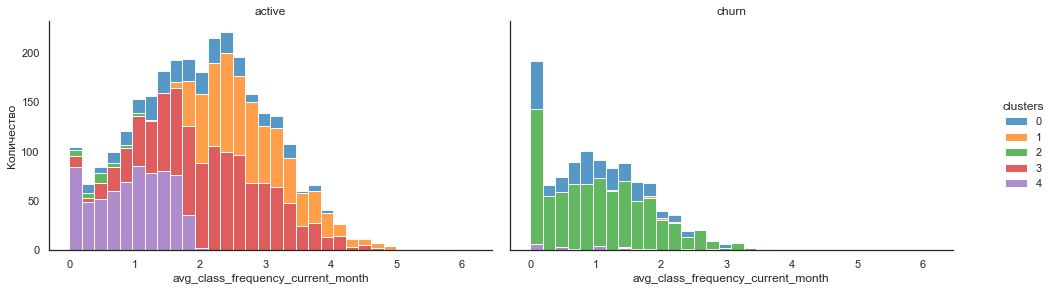

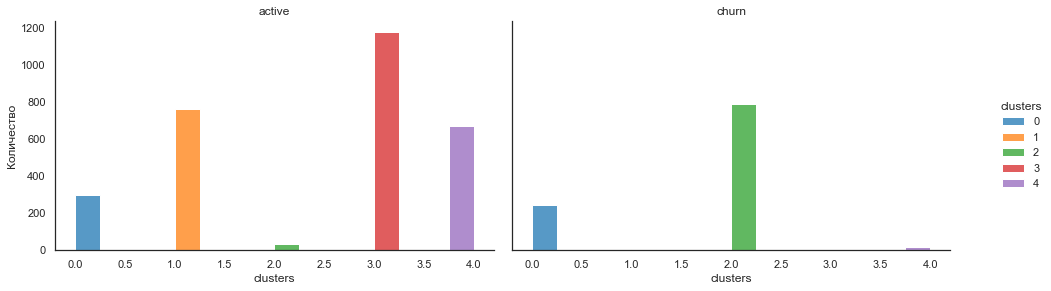

In [26]:
X = fitnes.drop(columns='churn')
fitnes_graph = fitnes.copy()
fitnes_graph['churn'] = fitnes_graph['churn'].replace([1,0],['churn','active'])

for name in X.columns:
  g = sns.displot(data=fitnes_graph, x=name, hue='clusters', palette='tab10', multiple='stack', col='churn')
  g.fig.set_figwidth(15)
  g.fig.set_figheight(4)
  g.set_axis_labels(name, "Количество")
  g.set_titles("{col_name}")
  plt.show()

Сделаем дополнительные выводы:

 - порядка 75 % всех клиентов живут или работают рядом с фитнес-центром;
 - половина клиентов не являются сотрудниками компании-партнера;
 - 25 % клиентов пришли по акции "приведи друга";
 - большинство клиентов покупают абонемент на минимальный срок;
 - треть клиентов не посещают групповые занятия;
 - гистограмма возраста имеет небольшой сдвиг в сторону молодежи;
 - гистограмма трат на доп.услуги у действующих клиентов в 2 раза выше "отвалившихся";
 - клиенты "живут" около 5 месяцев, но в большинстве случаев они ходят в клуб 1-2 месяца;
 - самый не надежный кластер в тоже время один из самых больших.

### <a id="4.5">Доля оттока по кластерам</a>

In [27]:
fitnes.groupby('clusters').agg({'churn':'mean'}).T

clusters,0,1,2,3,4
churn,0.450368,0.007823,0.961023,0.00339,0.024709


Кластер №2 является лидером по оттоку клиентов.<br>
Самыми надежными кластерами являются №1 и №3.

## <a id="load_data">Выводы</a>

В работе были проведены:
 - исследовательский анализ данных;
 - построены две модели прогнозирования оттока клиентов;
 - произведена кластеризация клиентов для определения признаков оттока клиентов.

В исследовательском анализе данных мы отметили, что на первый взгляд факторами оттока являются:
 - приобретение абонемента на месячный срок;
 - большинство клиентов не посещают групповые занятия;
 - основное распределение трат в диапазоне от 0 до 150, далее идет на снижение и совсем редко превышает 400;
 - у основной массы до конца абонемента остается 1 мес.;
 - распределение продолжительности посещения в основном сосредоточено на отметке в 1-2 месяца, далее резкий спад;
 - отсутствие специальных льготных условий обслуживания: компания-партнер или акция "приведи друга".

Модель логистической регрессии выдала наилучшие метрики, в дальнейшем для прогнозирования оттока клиентов можно применять именно ее.

Также все клиенты были поделены на кластеры, мы отметили, что:
 - клиенты "живут" до 5 месяцев, но в большинстве случаев они ходят в клуб 1-2 месяца;
 - мужчин и женщин поровну;
 - средний возраст самых надежных кластеров - 30 лет.

Рекомендуемые меры по удержанию клиентов:
 - добавить абонементы на 3 месяца(возможно кого то смущает сразу покупать на 6 мес.);
 - проведение промо-акций по групповым занятиям;
 - анализ и внедрение товаров и услуг с более высоким спросом, а возможно и пересмотр ценовой политики на доп.услуги;
 - развитие спецпрограмм для новых клиентов(возможно небольшой "тестдрайв");
 - возможно стоит провести опрос клиентов;
 - так же можно более тщательно исследовать кластеры №1 и №3.